CatBot Lab Context: This notebook supports the CatBot course and focuses on Position controller.

This is based on [1] and [2]
_________________

[1] Focchi, M., Del Prete, A., Havoutis, I., Featherstone, R., Caldwell, D. G., & Semini, C. (2017). High-slope terrain locomotion for torque-controlled quadruped robots. Autonomous Robots, 41(1), 259-272.

[2] Bledt, G., Powell, M. J., Katz, B., Di Carlo, J., Wensing, P. M., & Kim, S. (2018, October). MIT Cheetah 3: Design and control of a robust, dynamic quadruped robot. In 2018 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS) (pp. 2245-2252). IEEE.

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import os
from urdf_parser_py.urdf import URDF
import sys

%matplotlib inline

# POSITION controller

### Dynamical equation
\begin{equation}
T_{\phi, i}
\begin{cases}
0 \quad \text{swing} \\
1 \quad \text{stance}
\end{cases}
\end{equation}


\begin{equation}
\begin{cases}
m\ddot{\mathbf{x}}_{com} = \sum_i^4 T_{\phi,i} \mathbf{f}_i \\
I_G \dot{\mathbf{\omega}}_{b} = \sum_i^4 T_{\phi, i}(\mathbf{p}'_{com,i} \times \mathbf{f}_i)
\end{cases}
\end{equation}

Where $\mathbf{p}'_{com,i} = \mathbf{p}'_{com,i} + \mathbf{o}_i$. The variables $\mathbf{o}_i$ are offset positions of the feet that we are trying to compute. Therefore we get


\begin{equation}
\begin{cases}
m\ddot{\mathbf{x}}_{com} = \sum_i^4 T_{\phi,i} \mathbf{f}_i \\
I_G \dot{\mathbf{\omega}}_{b} + \sum_i^4 T_{\phi, i} \mathbf{f}_i  \times (\mathbf{p}_{com,i} ) = -\sum_i^4 T_{\phi, i} \mathbf{f}_i  \times (\mathbf{o}_{i} )
\end{cases}
\end{equation}

We compute the desired acceleration of the center of mass, $\mathbf{\ddot{x}}_{com}$  using a PD control law:

\begin{equation}
\mathbf{\ddot{x}}_{com}^{d} = K_{p,com} (\mathbf{x}_{com}^{d} - \mathbf{x}_{com}) + K_{d,com}(\mathbf{\dot{x}}_{com}^{d} - \mathbf{\dot{x}}_{com})
\end{equation}

now we can write our dynamical equation in matrix notation:

\begin{equation}
Ao = B
\end{equation}


where the $12$ unkowns in $f$ are
\begin{equation}
o = \begin{pmatrix}
T_{\phi,1}o_{1,x} \\
T_{\phi,1}o_{1,y} \\
T_{\phi,1}o_{1,z} \\
T_{\phi,2}o_{2,x} \\
T_{\phi,2}o_{2,y} \\
T_{\phi,2}o_{2,z} \\
T_{\phi,3}o_{3,x} \\
T_{\phi,3}o_{3,y} \\
T_{\phi,3}o_{3,z} \\
T_{\phi,4}o_{4,x} \\
T_{\phi,4}o_{4,y} \\
T_{\phi,4}o_{4,z} \\
\end{pmatrix}
\end{equation}

the matrix $A$ is:

\begin{equation}
A = 
\begin{pmatrix}
I_{3x3}                  & I_{3x3}                  & I_{3x3}                  & I_{3x3}                   \\
\mathbf{p}_{com,1}\times & \mathbf{p}_{com,2}\times & \mathbf{p}_{com,3}\times & \mathbf{p}_{com,4}\times 
\end{pmatrix}
\end{equation}

where the cross product matrix $\mathbf{p}_{com,i}\times$ is defined as follows:

\begin{equation}
\mathbf{p}_{com,i}\times \equiv 
\begin{pmatrix}
0                  & - p_{com,i}^{(z)}   &  p_{com,i}^{(y)}   \\
p_{com,i}^{(z)}    & 0                   &  -p_{com,i}^{(x)}  \\
-p_{com,i}^{(y)}   &   p_{com,i}^{(x)}   &  0                 \\
\end{pmatrix}
\end{equation}

and the expanded $A$ matrix, is a $6x12$ matrix:


\begin{equation}
A =
\begin{pmatrix}
1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 \\
0                  & - p_{com,0}^{(z)}   &  p_{com,0}^{(y)}   & 0                  & - p_{com,1}^{(z)}   &  p_{com,1}^{(y)} & 0                  & - p_{com,2}^{(z)}   &  p_{com,2}^{(y)} & 0                  & - p_{com,3}^{(z)}   &  p_{com,3}^{(y)} \\
p_{com,0}^{(z)}    & 0                   &  -p_{com,0}^{(x)}  & p_{com,1}^{(z)}    & 0                   &  -p_{com,1}^{(x)} & p_{com,2}^{(z)}    & 0                   &  -p_{com,2}^{(x)} & p_{com,3}^{(z)}    & 0                   &  -p_{com,3}^{(x)} \\
-p_{com,0}^{(y)}   &   p_{com,0}^{(x)}   &  0   & -p_{com,1}^{(y)}   &   p_{com,1}^{(x)}   &  0  & -p_{com,2}^{(y)}   &   p_{com,2}^{(x)}   &  0   & -p_{com,3}^{(y)}   &   p_{com,3}^{(x)}   &  0                
\end{pmatrix}
\end{equation}

while $B$ is a 6x1 matrix defined by:

\begin{equation}
B = 
\begin{pmatrix}
m \ddot{x}_{com}^{(x)} \\
m \ddot{y}_{com}^{(y)} \\
m (\ddot{x}_{com}^{(z)} - g) \\
I_{G,00} \dot{\omega}_b^{(x)} + I_{G,01} \dot{\omega}_b^{(y)} + I_{G,02} \dot{\omega}_b^{(z)}  \\
I_{G,10} \dot{\omega}_b^{(x)} + I_{G,11} \dot{\omega}_b^{(y)} + I_{G,12} \dot{\omega}_b^{(z)}  \\
I_{G,20} \dot{\omega}_b^{(x)} + I_{G,21} \dot{\omega}_b^{(y)} + I_{G,22} \dot{\omega}_b^{(z)}  \\
\end{pmatrix}
\end{equation}


The system of equations $Af = B$ has a total of 6 equations. We discuss the solutions of this system depending on how many feets are in stance:


   - If $4$ legs are in stance, the number of unkowns is $12$, so the system has infinite solutions (number of unkowns > number of equations). 
   - If $3$ legs are in stance, the number of unkowns is $9$, so the system has infinite solutions (number of unkowns > number of equations). 
   - If $2$ legs are in stance, the number of unkowns is $6$, so the system has a unique solution (number of unkowns = number of equations). 
   - If $1$ leg is in stance, the number of unkowns is $3$, so the system has no solutions (number of unkowns < number of equations). 


A solution for two or more legs in stance can be solved by obtaining forces $f$ that satisfy $Af - B = 0$.

However, we don't want any solution, we want to find forces $f$ that solve this system as much as possible while ensuring some limitations. For this we use quadratic programming



### Minimization

We solve the quadratic program:

\begin{equation}
f_d = 
\begin{cases}
\text{argmin}_{f}\Big[ (Af - B)^T S (Af - B) + \alpha \text{  norm($f$)} + \beta \text{  norm($f - f_{prev}$)} \Big]  \\
\text{s.t.} \quad d_{min} < Cf < d_{max}
\end{cases}
\end{equation}


Where $C$ is a $20x12$ matrix defined as:

\begin{equation}
C = 
\begin{pmatrix}
C_0 & 0   & 0   & 0    \\
0   & C_1 & 0   & 0    \\
0   & 0   & C_2 & 0    \\
0   & 0   & 0   & C_3  \\
\end{pmatrix}
\end{equation}

and each $C_i$ for $i=0,1,2,3$ is defined as a $5x3$ matrix:

\begin{equation}
C_i = 
\begin{pmatrix}
-\mu_i n_i^{(x)} + t_{1,i}^{(x)} & -\mu_i n_i^{(y)} + t_{1,i}^{(y)} & -\mu_i n_i^{(z)} + t_{1,i}^{(z)} \\
-\mu_i n_i^{(x)} + t_{2,i}^{(x)} & -\mu_i n_i^{(y)} + t_{2,i}^{(y)} & -\mu_i n_i^{(z)} + t_{2,i}^{(z)} \\
 \mu_i n_i^{(x)} + t_{2,i}^{(x)} &  \mu_i n_i^{(y)} + t_{2,i}^{(y)} &  \mu_i n_i^{(z)} + t_{2,i}^{(z)} \\
 \mu_i n_i^{(x)} + t_{1,i}^{(x)} &  \mu_i n_i^{(y)} + t_{1,i}^{(y)} &  \mu_i n_i^{(z)} + t_{1,i}^{(z)} \\
 n_i^{(x)}                       &  n_i^{(y)}                       &  n_i^{(z)}       
\end{pmatrix}
\end{equation}


and where $d_{max}$ and $d_{min}$ are $20x1$ matrices defined as:


\begin{equation}
d_{min} = 
\begin{pmatrix}
d_{min}^{0}  \\
d_{min}^{1}  \\
d_{min}^{2}  \\
d_{min}^{3}  \\
\end{pmatrix}
\quad\quad\quad\quad
d_{max} = 
\begin{pmatrix}
d_{max}^{0}  \\
d_{max}^{1}  \\
d_{max}^{2}  \\
d_{max}^{3}  \\
\end{pmatrix}
\end{equation}

and each $d_{min}^{i}$ and $d_{max}^{i}$ are $5x1$ matrices defined as:


\begin{equation}
d_{min}^{i} = 
\begin{pmatrix}
- \infty \\
- \infty \\
0        \\
0        \\
f_{min}^{i}
\end{pmatrix}
\quad\quad\quad\quad
d_{max}^{i} = 
\begin{pmatrix}
0        \\
0        \\
\infty   \\
\infty   \\
f_{max}^{i}
\end{pmatrix}
\end{equation}


### Specific case example

Let's symplify the calculus to an specific case where we have the same friction piramid for each leg defined by the friction coefficient $\mu$, the normal vector $\mathbf{n} = (0,0,1)$ and the tangent vectors $\mathbf{t_1} = (1,0,0)$ and $\mathbf{t_2} = (0,1,0)$. For each ground force $\mathbf{f}^{i}$ we have the same $C_i$ matrix:


\begin{equation}
C_i = 
\begin{pmatrix}
1    & 0    & -\mu \\
0    & 1    & -\mu \\
0    & 1    &  \mu \\ 
1    & 0    &  \mu \\
0    & 0    &  1   
\end{pmatrix}
\end{equation}

Now we can compute the inequalities for a single force $\mathbf{f}^{i}$ as
\begin{equation}
d_{min}^{i} < C_i\mathbf{f}^{i} < d_{max}^{i}
\end{equation}

or expanded:

\begin{equation}
\begin{pmatrix}
- \infty \\
- \infty \\
0        \\
0        \\
f_{min}^{i}
\end{pmatrix} <
\begin{pmatrix}
1    & 0    & -\mu \\
0    & 1    & -\mu \\
0    & 1    &  \mu \\ 
1    & 0    &  \mu \\
0    & 0    &  1   
\end{pmatrix} 
\begin{pmatrix}
f_x^i \\
f_y^i \\
f_z^i \\
\end{pmatrix} <
\begin{pmatrix}
0        \\
0        \\
\infty   \\
\infty   \\
f_{max}^{i}
\end{pmatrix}
\end{equation}

which gives the following 5 inequalities:

\begin{equation}
\begin{cases}
-\infty   \quad      < \quad f_x^i - \mu f_z^i \quad  <  \quad 0          \\
-\infty   \quad      < \quad f_y^i - \mu f_z^i \quad  <  \quad 0          \\
0         \quad\quad < \quad f_x^i + \mu f_z^i \quad  <  \quad \infty     \\
0         \quad\quad < \quad f_y^i + \mu f_z^i \quad  <  \quad \infty     \\
f_{min}^i \quad      < \quad f_z^i             \quad\quad\quad  <  \quad f_{max}^i  \\
\end{cases}
\end{equation}

and define a simple friction piramid with slope defined by $\mu$

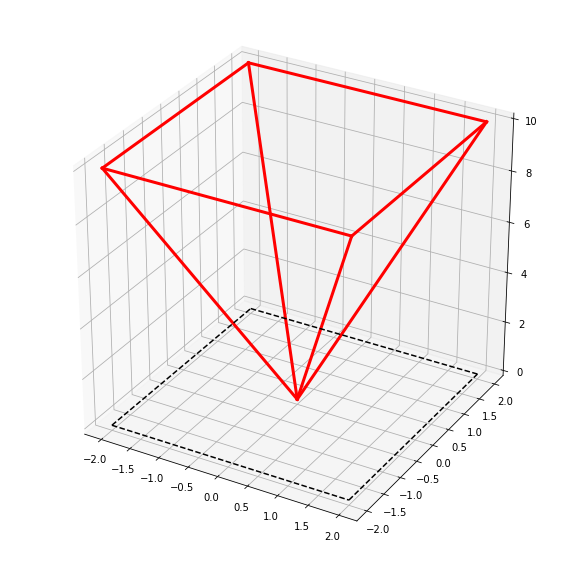

In [38]:
fmin = 0
fmax = 10
mu = 0.2

N_points = 100
fz_lim = np.linspace(fmin, fmax, N_points)

fx_lim_max =  mu*fz_lim
fx_lim_min = -mu*fz_lim

fy_lim_max =  mu*fz_lim
fy_lim_min = -mu*fz_lim

fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot(fx_lim_min, fy_lim_min, fz_lim, color = 'red', linewidth = 3)
ax.plot(fx_lim_min, fy_lim_max, fz_lim, color = 'red', linewidth = 3)
ax.plot(fx_lim_max, fy_lim_min, fz_lim, color = 'red', linewidth = 3)
ax.plot(fx_lim_max, fy_lim_max, fz_lim, color = 'red', linewidth = 3)


ax.plot([fx_lim_min[-1], fx_lim_max[-1]], [fy_lim_max[-1], fy_lim_max[-1]], [fmax]*2, color = 'red', linewidth = 3)
ax.plot([fx_lim_min[-1], fx_lim_max[-1]], [fy_lim_min[-1], fy_lim_min[-1]], [fmax]*2, color = 'red', linewidth = 3)
ax.plot([fx_lim_min[-1], fx_lim_min[-1]], [fy_lim_min[-1], fy_lim_max[-1]], [fmax]*2, color = 'red', linewidth = 3)
ax.plot([fx_lim_max[-1], fx_lim_max[-1]], [fy_lim_min[-1], fy_lim_max[-1]], [fmax]*2, color = 'red', linewidth = 3)


ax.plot([fx_lim_min[0], fx_lim_max[0]], [fy_lim_max[0], fy_lim_max[0]], [fmin]*2, color = 'red', linewidth = 3)
ax.plot([fx_lim_min[0], fx_lim_max[0]], [fy_lim_min[0], fy_lim_min[0]], [fmin]*2, color = 'red', linewidth = 3)
ax.plot([fx_lim_min[0], fx_lim_min[0]], [fy_lim_min[0], fy_lim_max[0]], [fmin]*2, color = 'red', linewidth = 3)
ax.plot([fx_lim_max[0], fx_lim_max[0]], [fy_lim_min[0], fy_lim_max[0]], [fmin]*2, color = 'red', linewidth = 3)


ax.plot([fx_lim_min[-1], fx_lim_max[-1]], [fy_lim_max[-1], fy_lim_max[-1]], [0]*2, color = 'black', linestyle = 'dashed')
ax.plot([fx_lim_min[-1], fx_lim_max[-1]], [fy_lim_min[-1], fy_lim_min[-1]], [0]*2, color = 'black', linestyle = 'dashed')
ax.plot([fx_lim_min[-1], fx_lim_min[-1]], [fy_lim_min[-1], fy_lim_max[-1]], [0]*2, color = 'black', linestyle = 'dashed')
ax.plot([fx_lim_max[-1], fx_lim_max[-1]], [fy_lim_min[-1], fy_lim_max[-1]], [0]*2, color = 'black', linestyle = 'dashed')



ax.plot([fx_lim_min[0], fx_lim_max[0]], [fy_lim_max[0], fy_lim_max[0]], [0]*2, color = 'black', linestyle = 'dashed')
ax.plot([fx_lim_min[0], fx_lim_max[0]], [fy_lim_min[0], fy_lim_min[0]], [0]*2, color = 'black', linestyle = 'dashed')
ax.plot([fx_lim_min[0], fx_lim_min[0]], [fy_lim_min[0], fy_lim_max[0]], [0]*2, color = 'black', linestyle = 'dashed')
ax.plot([fx_lim_max[0], fx_lim_max[0]], [fy_lim_min[0], fy_lim_max[0]], [0]*2, color = 'black', linestyle = 'dashed')


# Quadratic program

A stantard quadratic program is stated as:

\begin{equation}
\begin{cases}
\text{minimize}_{x}\Big[ \frac{1}{2}x^TPx + q^T x\Big]  \\
\text{subject to} \quad Gx \leq h \\
\quad\quad\quad\quad Ax = B
\end{cases}
\end{equation}


The quadratic program in the torque controller:

\begin{equation}
f_d = 
\begin{cases}
\text{argmin}_{f}\Big[ (Af - B)^T S (Af - B) + \alpha ||f||_2^2+ \beta ||f - f_{prev}||_2^2 \Big]  \\
\text{s.t.} \quad d_{min} < Cf < d_{max}
\end{cases}
\end{equation}

Can be written in the standard quadratic program with the following calculation. Take into account the following equalities:
 \begin{equation}
 \begin{cases}
 ||M||_2^2 = M^T M \\
 (MN)^T = N^T M^T
 \end{cases}
 \end{equation}
 
 The algebra that leads the previous cost function to a quadratic program is the following:
 
 
 \begin{equation}
 (Af - B)^T S (Af - B) + \alpha ||f||_2^2+ \beta ||f - f_{prev}||_2^2 = \\
 (f^T A^T - B^T) S (Af - B) + \alpha f^Tf+ \beta (f^T - f_{prev}^T)(f - f_{prev}) = \\
 f^TA^TSAf - B^TSAf - f^TA^TSB + B^TSB + \alpha f^Tf + \beta f^Tf - \beta f_{prev}^Tf - \beta f^Tf_{prev} + \beta f_{prev}^Tf_{prev} =  \\
  f^T(  A^TSA + \alpha I + \beta I )f - (B^TSA + \beta f_{prev}^T)f - f^T( A^TSB + \beta f_{prev} ) + \beta f_{prev}^Tf_{prev} = \\
  ...
 \end{equation}

The last term, $\beta f_{prev}^Tf_{prev}$, is an offset and does not affect the minimization for $f$, so we can eliminate it. Take into account now that the term $f^T( A^TSB + \beta f_{prev} )$ is a number, not a matrix. And for any real number $a \in \Re$ we have that $a = a^T$. Therefore

\begin{equation}
f^T( A^TSB + \beta f_{prev} ) = \Big( f^T( A^TSB + \beta f_{prev} ) \Big)^T = ( A^TSB + \beta f_{prev} )^Tf = 
(B^TS^TA + \beta f_{prev}^T)f
\end{equation}

We can therefore combine the second and third term in the cost function because the matrix $S$ is a diagonal matrix, so that $S = S^T$. In addition we mutiply the cost function by $1/2$ because it does not change the minimization. Therefore we obtain

\begin{equation}
... \propto \frac{1}{2} f^T(  A^TSA + \alpha I + \beta I )f + (-B^TSA - \beta f_{prev}^T)f = \frac{1}{2} f^T(  A^TSA + \alpha I + \beta I )f + (-A^TSB - \beta f_{prev})^T f
\end{equation}


Therefore in the standar Quadratic program notation,
\begin{equation}
P = A^T S A + \alpha I + \beta I \quad\quad q^T = (-A^TSB - \beta f_{prev})^T
\end{equation}

(see proof https://scaron.info/blog/quadratic-programming-in-python.html and 
http://maggotroot.blogspot.com/2013/11/constrained-linear-least-squares-in.html)

In [10]:
print(A.shape)

(6, 12)


### Load URDF

In [4]:
URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/catbot_description/urdf/'
urdf_model     = URDF_DIR + 'catbot.urdf'\

urdf_str = open(urdf_model, 'r').read()
robot_urdf = URDF.from_xml_string(urdf_str)

### Get Feet positions

In [6]:
def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0,             0],
                   [0,            np.cos(roll),   -np.sin(roll), 0],
                   [0,            np.sin(roll),   np.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = np.array([[np.cos(yaw),  0,              np.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-np.sin(yaw), 0,              np.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = np.array([[np.cos(pit), -np.sin(pit),   0,             0],
                   [np.sin(pit),  np.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = np.array([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = np.dot(Rz,Ry).dot(Rx)
    
    return T_pos.dot(Rxyz)


def getJointTransforms(robot_urdf, leg, angles):
    tf_joints = {}

    for joint in robot_urdf.joints:
        if leg in joint.name:
            pos       = np.array(joint.origin.xyz)
            euler_ang = np.zeros(3)
            
            
            if 'hip1' in joint.name:
                euler_ang[0] = angles[0]
                tf_joints['hip1'] = getTransform(pos, euler_ang)
            
            if 'hip2' in joint.name:
                euler_ang[2] = angles[1]
                tf_joints['hip2'] = getTransform(pos, euler_ang)
                
            if 'knee' in joint.name:
                euler_ang[2] = angles[2]                
                tf_joints['knee'] = getTransform(pos, euler_ang)
            if 'feet' in joint.name:
                
                tf_joints['feet'] = getTransform(pos, euler_ang)
        
    return tf_joints


def getJointPositions(robot_urdf, leg, angles):
    tf_joints = getJointTransforms(robot_urdf, leg, angles)
        
    initial_pose = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, 0],
                             [0, 0, 0, 1]])
    
    
    pose_hip   = initial_pose.dot(tf_joints['hip1'])
    pose_femur = pose_hip.dot(tf_joints['hip2'])
    pose_tibia = pose_femur.dot(tf_joints['knee'])
    pose_feet  = pose_tibia.dot(tf_joints['feet'])
    

    pos_hip    = np.array([pose_hip[0, 3],   pose_hip[1, 3],   pose_hip[2, 3]])
    pos_femur  = np.array([pose_femur[0, 3], pose_femur[1, 3], pose_femur[2, 3]])
    pos_tibia  = np.array([pose_tibia[0, 3], pose_tibia[1, 3], pose_tibia[2, 3]])
    pos_feet   = np.array([pose_feet[0, 3],  pose_feet[1, 3],  pose_feet[2, 3]])
    
    return np.array([pos_hip, pos_femur, pos_tibia, pos_feet])




angles = np.degrees([0,45,-90])
feet_pos_fl = getJointPositions(robot_urdf, 'fl', angles)[3]
feet_pos_fr = getJointPositions(robot_urdf, 'fl', angles)[3]
feet_pos_bl = getJointPositions(robot_urdf, 'fl', angles)[3]
feet_pos_br = getJointPositions(robot_urdf, 'fl', angles)[3]



In [200]:
def pcom_crossproduct_matrix(feet_pos):
    p_com = np.array([[ 0,           -feet_pos[2],  feet_pos[1]],
                      [ feet_pos[2],  0,           -feet_pos[0]],
                      [-feet_pos[1],  feet_pos[0],  0          ]])
    return p_com





def getAmatrix(feet_pos):
    I = np.eye(3)
    p_com_fl = pcom_crossproduct_matrix(feet_pos['fl'])
    p_com_fr = pcom_crossproduct_matrix(feet_pos['fr'])
    p_com_bl = pcom_crossproduct_matrix(feet_pos['bl'])
    p_com_br = pcom_crossproduct_matrix(feet_pos['br'])
    A = np.vstack( [ np.hstack([I, I, I, I])  , np.hstack([p_com_fl, p_com_fr, p_com_bl, p_com_br]) ] )
    return A

def getBmatrix(m, I_G, lin_acc_CoM, ang_acc_CoM):
    g = np.array([[0,0,-9.8]]).T
    B = np.vstack( [ np.dot(I_G, ang_acc_CoM), m*(lin_acc_CoM - g )  ]  )
    return B
    

### Robot mass and inertia ###
m = 3 # Kg
I_G = 0.01*np.eye(3)

### Robot feet positions ###
feet_pos = {}
feet_pos['fl'] = np.array([-0.1,0.1,0.1])
feet_pos['fr'] = np.array([0.1,0.1,0.1])
feet_pos['bl'] = np.array([-0.1,-0.1,0.1])
feet_pos['br'] = np.array([0.1,-0.1,0.1])


### Desired behavior of the CoM ###
lin_acc_CoM = np.array([[0, 0, 0]]).T
ang_acc_CoM = np.array([[0,   0, 0]]).T


A = getAmatrix(feet_pos)
B = getBmatrix(m, I_G, lin_acc_CoM, ang_acc_CoM)


print(A)
print(A.shape)
print("")
print(B)
print(B.shape)


[[ 1.   0.   0.   1.   0.   0.   1.   0.   0.   1.   0.   0. ]
 [ 0.   1.   0.   0.   1.   0.   0.   1.   0.   0.   1.   0. ]
 [ 0.   0.   1.   0.   0.   1.   0.   0.   1.   0.   0.   1. ]
 [ 0.  -0.1  0.1  0.  -0.1  0.1  0.  -0.1 -0.1  0.  -0.1 -0.1]
 [ 0.1  0.   0.1  0.1  0.  -0.1  0.1  0.   0.1  0.1  0.  -0.1]
 [-0.1 -0.1  0.  -0.1  0.1  0.   0.1 -0.1  0.   0.1  0.1  0. ]]
(6, 12)

[[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [29.4]]
(6, 1)


In [237]:
def friction_matrix(n, t1, t2, mu):
    C = np.vstack( [(-mu*n + t1).T, 
                    (-mu*n + t2).T,
                    (mu*n + t1).T,
                    (mu*n + t2).T,
                    n.T])
    return C
    
def min_friction_lim(fmin):
    d_min = np.array([[-np.inf, -np.inf, 0, 0, fmin]]).T
    return d_min

def max_friction_lim(fmax):
    d_max = np.array([[0, 0, np.inf, np.inf, fmax]]).T
    return d_max


def getCmatrix(nm, t1, t2, mu):
    C_i     = friction_matrix(nm, t1, t2, mu)
    zero_matrix = np.zeros(C_i.shape)

    C = np.vstack(  [  np.hstack([C_i, zero_matrix, zero_matrix, zero_matrix  ]),
                       np.hstack([zero_matrix, C_i, zero_matrix, zero_matrix  ]),
                       np.hstack([zero_matrix, zero_matrix, C_i, zero_matrix  ]),
                       np.hstack([zero_matrix, zero_matrix, zero_matrix, C_i  ])  ] )
    
    return C
    
    
def dminMatrix(fmin):
    d_min_i = min_friction_lim(fmin)
    d_min = np.vstack([d_min_i, d_min_i, d_min_i, d_min_i])
    return d_min
    
def dmaxMatrix(fmax):
    d_max_i = max_friction_lim(fmax)
    d_max = np.vstack([d_max_i, d_max_i, d_max_i, d_max_i])
    return d_max
    
    

### constants ###
mu = 0.25
fmin = 0
fmax = 100


nm = np.array([[0,0,1]]).T
t1 = np.array([[1,0,0]]).T
t2 = np.array([[0,1,0]]).T

C     = getCmatrix(nm, t1, t2, mu)
d_min = dminMatrix(fmin)
d_max = dmaxMatrix(fmax)



print(C)
print(C.shape)
print("")
print(d_min)
print(d_min.shape)
print("")
print(d_max)
print(d_max.shape)
print("")

[[ 1.    0.   -0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.   -0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 1.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.   -0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.   -0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.   -0.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.   -0.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.  

In [7]:
# Install quadprog package
!pip install quadprog

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Created wheel for quadprog: filename=quadprog-0.1.7-cp27-cp27mu-linux_x86_64.whl size=162619 sha256=ab47ae90a1fb6d07e1bb532dff0eb93b8dc0d9bdb375930b1d4a5aef69eb2c01
  Stored in directory: /home/andres/.cache/pip/wheels/70/e9/a8/f9e9c4ee08bb690fc24b33af704716af5c1734ff0b93ea3cd5
Successfully built quadprog
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [8]:
from numpy import hstack, vstack
from quadprog import solve_qp
import time

In [9]:
def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None, initvals=None,
                      verbose=False):
    """
    Solve a Quadratic Program defined as:
    .. math::
        \\begin{split}\\begin{array}{ll}
        \\mbox{minimize} &
            \\frac{1}{2} x^T P x + q^T x \\\\
        \\mbox{subject to}
            & G x \\leq h                \\\\
            & A x = h
        \\end{array}\\end{split}
    using `quadprog <https://pypi.python.org/pypi/quadprog/>`_.
    Parameters
    ----------
    P : numpy.array
        Symmetric quadratic-cost matrix.
    q : numpy.array
        Quadratic-cost vector.
    G : numpy.array
        Linear inequality constraint matrix.
    h : numpy.array
        Linear inequality constraint vector.
    A : numpy.array, optional
        Linear equality constraint matrix.
    b : numpy.array, optional
        Linear equality constraint vector.
    initvals : numpy.array, optional
        Warm-start guess vector (not used).
    verbose : bool, optional
        This argument has no effect, it is here for API conformance.
    Returns
    -------
    x : numpy.array
        Solution to the QP, if found, otherwise ``None``.
    Note
    ----
    The quadprog solver only considers the lower entries of `P`, therefore it
    will use a wrong cost function if a non-symmetric matrix is provided.
    """
    if initvals is not None:
        print("quadprog: note that warm-start values ignored by wrapper")
    qp_G = P
    qp_a = -q
    if A is not None:
        if G is None:
            qp_C = -A.T
            qp_b = -b
        else:
            qp_C = -np.vstack([A, G]).T
            qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T if G is not None else None
        qp_b = -h if h is not None else None
        meq = 0
    try:
        return solve_qp(qp_G, qp_a[0], qp_C, qp_b[:,0], meq)[0]
        return solve_qp(qp_G, qp_a[0], qp_C, qp_b, meq)[0]

    except ValueError as e:
        if "matrix G is not positive definite" in e:
            # quadprog writes G the cost matrix that we write P in this package
            raise ValueError("matrix P is not positive definite")
        raise

# Stupid example

In [32]:
P = np.eye(3)
q = -100*np.ones([1,3])
G = np.eye(3)
h = 50*np.ones([3,1])

quadprog_solve_qp(P,q,G,h)

array([50., 50., 50.])

In [238]:
def get_forces(A, B, C, d_min, d_max, alpha, beta, f_prev):
    S = np.ones([6, 6])
    I = np.eye(12)

    P = A.T.dot(S.dot(A)) + alpha*I + beta*I
    qT = -(A.T.dot(S.dot(B)) + beta * f_prev)
    q = qT.T
    f = quadprog_solve_qp(P, q, C, d_max)
    return f

alpha = 0.0
beta  = 0.001
f_leg = np.array([0,0, m*9.8/4])
f_prev = np.array([np.hstack([f_leg, f_leg, f_leg, f_leg])]).T
timer = time.time()


for i in range(5):
    f = get_forces(A, B, C, d_min, d_max, alpha, beta, f_prev)
    print(f)
    print('delayed time {:.5f}'.format(time.time() - timer))
    f_prev = f
    timer = time.time()
    print('')

[-8.82235703e-13 -3.73465153e-12  7.35000000e+00 -6.53249601e-13
  5.41776983e-13  7.35000000e+00  2.77579868e-12 -7.28840423e-13
  7.35000000e+00  2.43491077e-12 -1.16677194e-12  7.35000000e+00]
delayed time 0.00077

[1.34062927 1.34062927 5.3625171  1.21875389 1.21875389 4.87501555
 1.21875389 1.21875389 4.87501555 1.0968785  1.0968785  4.38751399]
delayed time 0.00037

[1.29844805 1.29844805 5.19379221 1.22103245 1.22103245 4.8841298
 1.22103245 1.22103245 4.8841298  1.14361685 1.14361685 4.57446739]
delayed time 0.00055

[1.29977523 1.29977523 5.19910093 1.22096076 1.22096076 4.88384303
 1.22096076 1.22096076 4.88384303 1.14214628 1.14214628 4.56858514]
delayed time 0.00068

[1.29973347 1.29973347 5.1989339  1.22096301 1.22096301 4.88385206
 1.22096301 1.22096301 4.88385206 1.14219255 1.14219255 4.56877021]
delayed time 0.00057



In [68]:
Q = 2*qp.matrix([ [2, .5], [.5, 1] ])
p = qp.matrix([1.0, 1.0])
G = qp.matrix([[-1.0,0.0],[0.0,-1.0]])
h = qp.matrix([0.0,0.0])
A = qp.matrix([1.0, 1.0], (1,2))
b = qp.matrix(1.0)
sol=qp.solvers.qp(Q, p, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  1e-16  5e-08
Optimal solution found.
{'status': 'optimal', 'dual slack': 1.0000000000000038e-08, 'iterations': 4, 'relative gap': 5.614415451491214e-08, 'dual objective': 1.8749998947297342, 'gap': 1.052702838051502e-07, 'primal objective': 1.875000000000018, 'primal slack': 0.2500000952702475, 's': <2x1 matrix, tc='d'>, 'primal infeasibility': 1.1102230246251565e-16, 'dual infeasibility': 5.3147592893303475e-08, 'y': <1x1 matrix, tc='d'>, 'x': <2x1 matrix, tc='d'>, 'z': <2x1 matrix, tc='d'>}


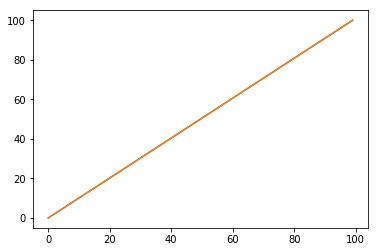

In [46]:

def func(x, a, b,c):
    return a * (1 - np.exp(-b * (x - c)))

def invFunc(y,a,b,c):
    return c-(1./b)*np.log(1 - np.true_divide(y, a))

x_fit = np.linspace(0,100,100)

a = 10
b = 0.1
c = 0

y_fit = func(x_fit, a,b,c)
x_inv = invFunc(y_fit, a,b,c)

plt.plot(x_fit)#, y_fit)
plt.plot(x_inv)#, y_fit)


In [18]:
np.log(np.e)

1.0

In [6]:
def torque(sensor):
    return 0.0000954054*sensor**2 + 0.0232942673*sensor + 0.0275110072 

torque(32.65)

0.8897731375665

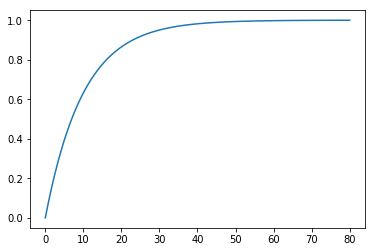

In [9]:
x_fit = np.linspace(0,80,100)
y_fit = 1*(1 - np.exp(-0.1*x_fit))

plt.plot(x_fit, y_fit)

If monotonic:
\begin{equation}
    \tau = A (1 - e^{-B (s - s_0) } )
\end{equation}

else:
\begin{equation}
    \tau = A (e^{-B (s - s_0) } )
\end{equation}

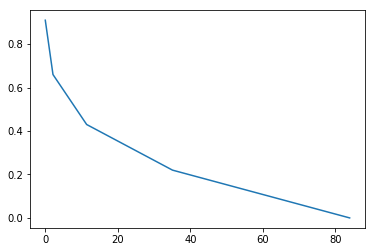

In [46]:
from scipy.optimize import curve_fit

y = [0, 0.22, 0.43, 0.66, 0.91]
x = np.flip(np.array([-0.12, 2, 11.29, 34.96, 83.82])) + 1000

offset = np.min(x)

plt.plot(x - offset,y)

[83.94 81.82 72.53 48.86  0.  ]


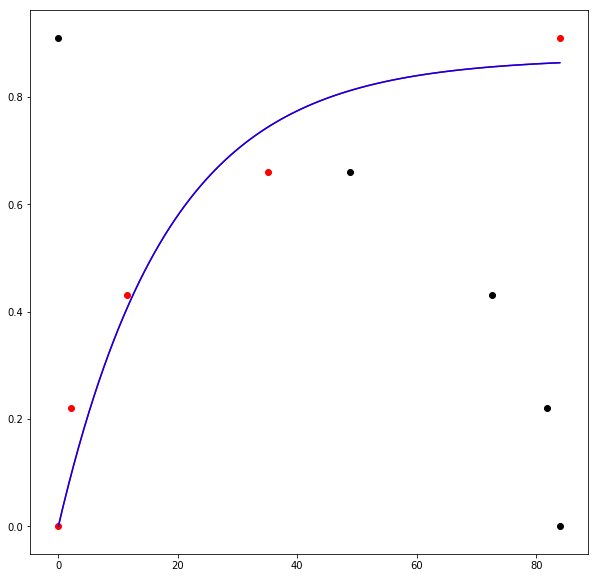

In [55]:
from scipy.optimize import curve_fit

y = np.array([0, 0.22, 0.43, 0.66, 0.91])
x = -np.array([-0.12, 2, 11.29, 34.96, 83.82])

x -= np.min(x)

print(x)

plt.figure(figsize = (10,10))
plt.scatter(x,y, color = 'black')

mirrored_x = -x
mirrored_x -= np.min(mirrored_x)

plt.scatter(mirrored_x,y, color = 'red')

def func(x, a, b):
    return a * (1 - np.exp(-b * x))


def funcFlip(x, a, b):
    return a * (1- np.exp(-b * x))


popt, pcov = curve_fit(func, mirrored_x, y)

x_fit = np.linspace(np.min(x),np.max(x),100)
y_fit = func(x_fit, popt[0], popt[1])

y_fit_2 = funcFlip(x_fit, popt[0], popt[1])


plt.plot(x_fit, y_fit, color = 'red')
plt.plot(x_fit, y_fit_2, color = 'blue')


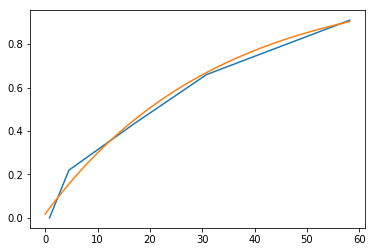

In [16]:
y = [0, 0.22, 0.43, 0.66, 0.91]
x = np.array([ 0.8, 4.52, 16.77, 30.83, 58.17]) + 1000 

x -= 1000

plt.plot(x,y)


popt, pcov = curve_fit(func, x, y)

x_fit = np.linspace(0,np.max(x),100)
y_fit = func(x_fit, popt[0], popt[1], popt[2])

plt.plot(x_fit, y_fit)

In [7]:
import numpy as np

a = np.zeros([30,30])


b = np.stack([a,a,a])
b = b.reshape([30,30,3])
print(b.shape)

(30, 30, 3)


# How to control feet pressure with 2 torque sensors

We only measure torque in the joints hip1 and knee and we get an output for the torque controller as a 3D vector